In [13]:
# Only needed if not already installed
!pip install openpyxl --quiet


In [14]:
#STEP 2: Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings("ignore")


In [15]:
# Load the Excel file
df = pd.read_excel("Daily_Ridership_Data_Formatted.xlsx")

# Show the first few rows
df.head()


,Year,Month,Day,Type,Daily Ridership
0,2015,1,1,Bus,3621958
1,2015,1,1,MRT,3171155
2,2015,1,1,LRT,120860
3,2015,1,2,Bus,3865838
4,2015,1,2,MRT,2759178


In [16]:
#4: Preprocess the Data
# Combine year, month, day into a single datetime column
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

# Sort by date
df = df.sort_values('Date')

# Pivot the data so that each mode is a column
df_pivot = df.pivot_table(index='Date', columns='Type', values='Daily Ridership')

# Fill any missing values
df_pivot = df_pivot.fillna(method='ffill')

# Check final structure
df_pivot.head()


Type,Bus,LRT,MRT
Date,,,
2015-01-01,3621958.0,120860.0,3171155.0
2015-01-02,3865838.0,196820.0,2759178.0
2015-01-03,3554886.0,157194.0,2637337.0
2015-01-04,3587498.0,180263.0,2675203.0
2015-01-05,3778167.0,187221.0,2541090.0


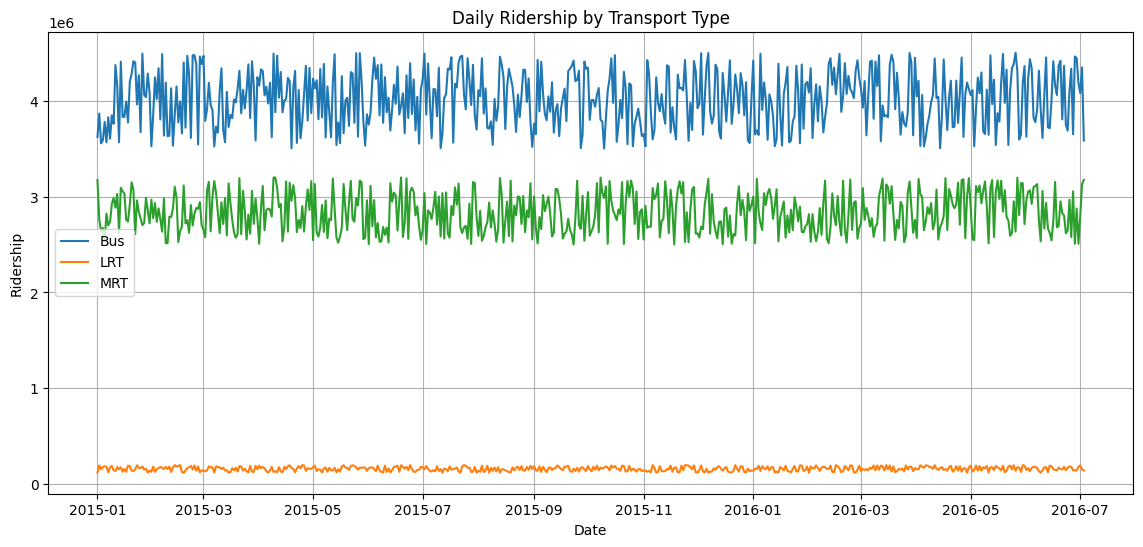

In [17]:
#Visualize the Ridership
plt.figure(figsize=(14, 6))
for col in df_pivot.columns:
    plt.plot(df_pivot.index, df_pivot[col], label=col)
plt.title("Daily Ridership by Transport Type")
plt.xlabel("Date")
plt.ylabel("Ridership")
plt.legend()
plt.grid(True)
plt.show()


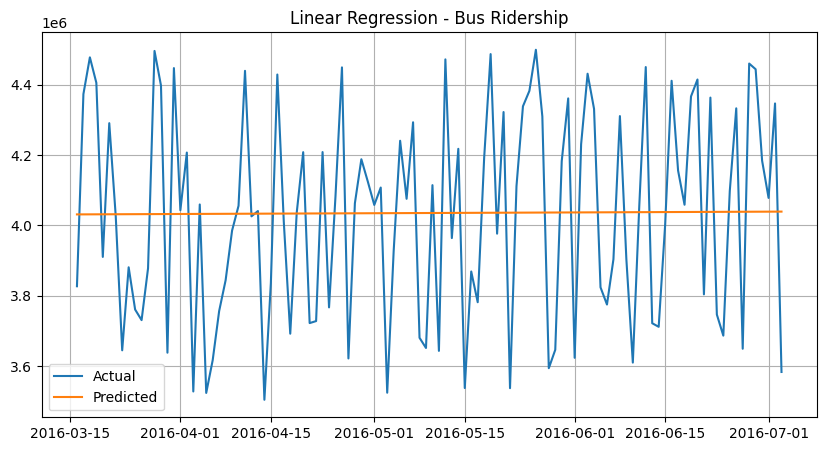

In [18]:
#6: Forecasting with LINEAR REGRESSION
#we'll predict Bus Ridership as an example:
# Add numerical time index for Linear Regression
df_pivot['Time'] = np.arange(len(df_pivot))

# Features and labels
X = df_pivot[['Time']]
y = df_pivot['Bus']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# Train Linear Regression
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

# Predict
y_pred = model_lr.predict(X_test)

# Plot actual vs predicted
plt.figure(figsize=(10,5))
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.title('Linear Regression - Bus Ridership')
plt.legend()
plt.grid(True)
plt.show()


Forecasting Bus...


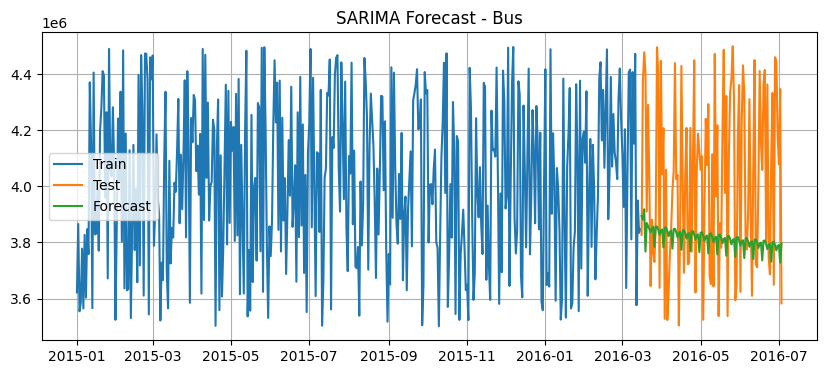

Forecasting MRT...


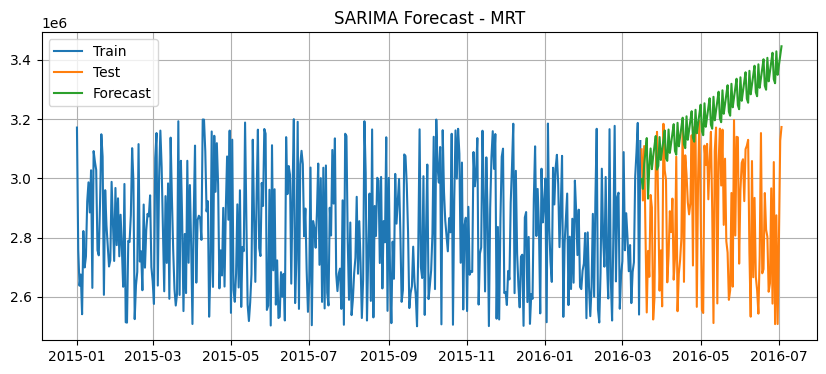

Forecasting LRT...


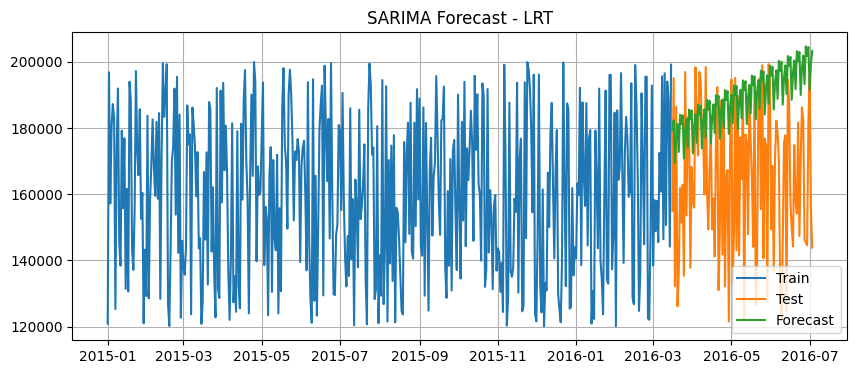

In [19]:
#7: Forecasting with SARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

forecast_results = {}

for mode in ['Bus', 'MRT', 'LRT']:
    print(f"Forecasting {mode}...")
    series = df_pivot[mode]

    train_len = int(len(series) * 0.8)
    train = series[:train_len]
    test = series[train_len:]

    model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
    result = model.fit()

    forecast = result.predict(start=len(train), end=len(series)-1)

    # Save forecast to dict
    forecast_results[mode] = {
        "train": train,
        "test": test,
        "forecast": forecast
    }

    # Plot
    plt.figure(figsize=(10,4))
    plt.plot(train.index, train, label="Train")
    plt.plot(test.index, test, label="Test")
    plt.plot(test.index, forecast, label="Forecast")
    plt.title(f"SARIMA Forecast - {mode}")
    plt.legend()
    plt.grid(True)
    plt.show()



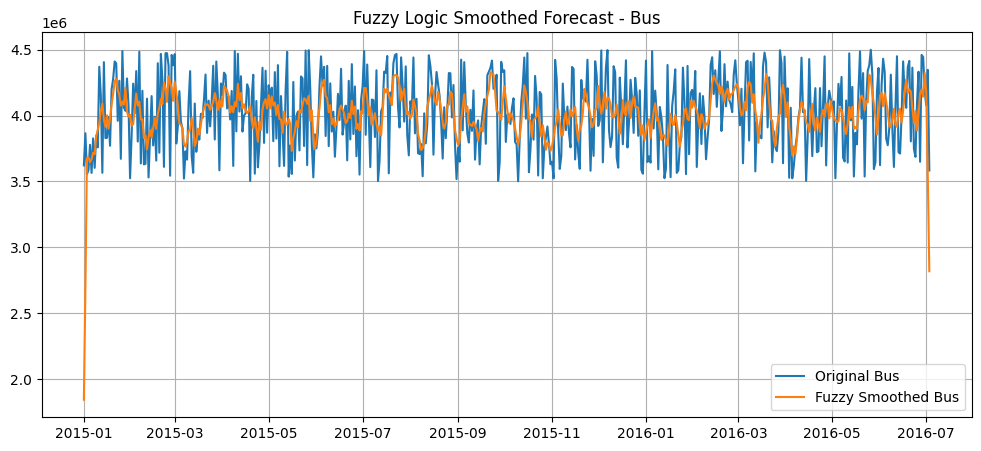

In [20]:
#8:  Fuzzy Logic Forecasting
def fuzzy_weighted_smooth(series, window=5):
    weights = np.linspace(1, 2, window)  # fuzzy-style increasing weights
    weights /= weights.sum()
    return np.convolve(series, weights, mode='same')

fuzzy_smoothed = pd.DataFrame(index=df_pivot.index)

for col in ['Bus', 'MRT', 'LRT']:
    fuzzy_smoothed[col + '_Smoothed'] = fuzzy_weighted_smooth(df_pivot[col].values)

# Plot example
plt.figure(figsize=(12, 5))
plt.plot(df_pivot.index, df_pivot['Bus'], label='Original Bus')
plt.plot(fuzzy_smoothed.index, fuzzy_smoothed['Bus_Smoothed'], label='Fuzzy Smoothed Bus')
plt.legend()
plt.title("Fuzzy Logic Smoothed Forecast - Bus")
plt.grid(True)
plt.show()



In [22]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np

# Filter for a single type (e.g., Bus)
type_filter = 'Bus'
data = df[df['Type'] == type_filter]

# Set datetime index
data['Date'] = pd.to_datetime(data[['Year', 'Month', 'Day']])
data.set_index('Date', inplace=True)
ts = data['Daily Ridership'].asfreq('D')

# Train-test split (80-20 split)
train_size = int(len(ts) * 0.8)
train, test = ts[:train_size], ts[train_size:]

# Train SARIMA
model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,7))  # Example order
model_fit = model.fit(disp=False)

# Forecast
forecast = model_fit.predict(start=test.index[0], end=test.index[-1])

# Evaluate
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
mape = mean_absolute_percentage_error(test, forecast) * 100

print(f"Performance for {type_filter}:")
print("MAE:", round(mae, 2))
print("RMSE:", round(rmse, 2))
print("MAPE:", round(mape, 2), "%")


Performance for Bus:
MAE: 311868.93
RMSE: 373480.92
MAPE: 7.48 %



🔍 Transport Type: Bus
MAE: 311868.93
RMSE: 373480.92
MAPE: 7.48 %


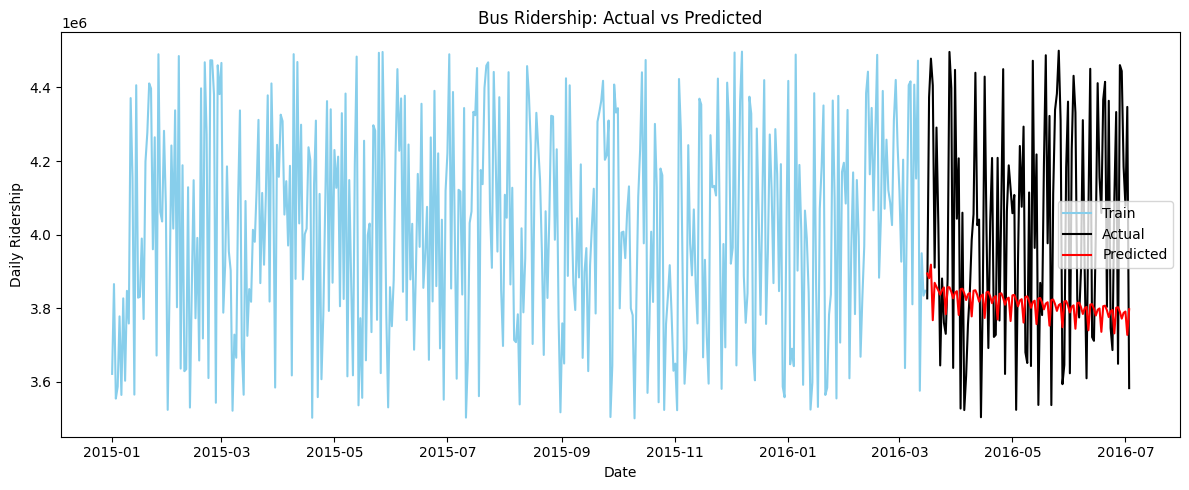


🔍 Transport Type: MRT
MAE: 353412.34
RMSE: 422056.44
MAPE: 12.92 %


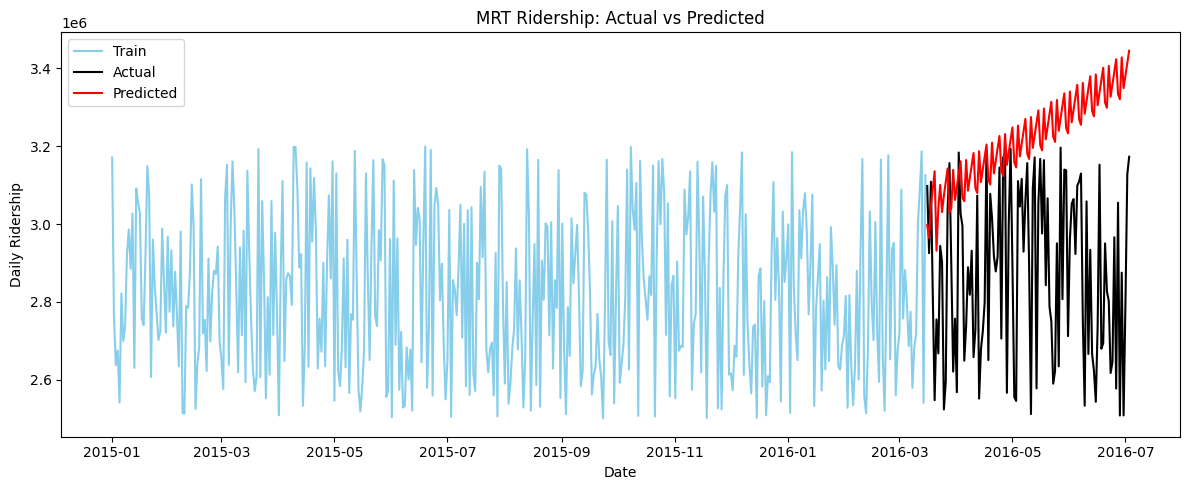


🔍 Transport Type: LRT
MAE: 27863.98
RMSE: 33944.85
MAPE: 18.83 %


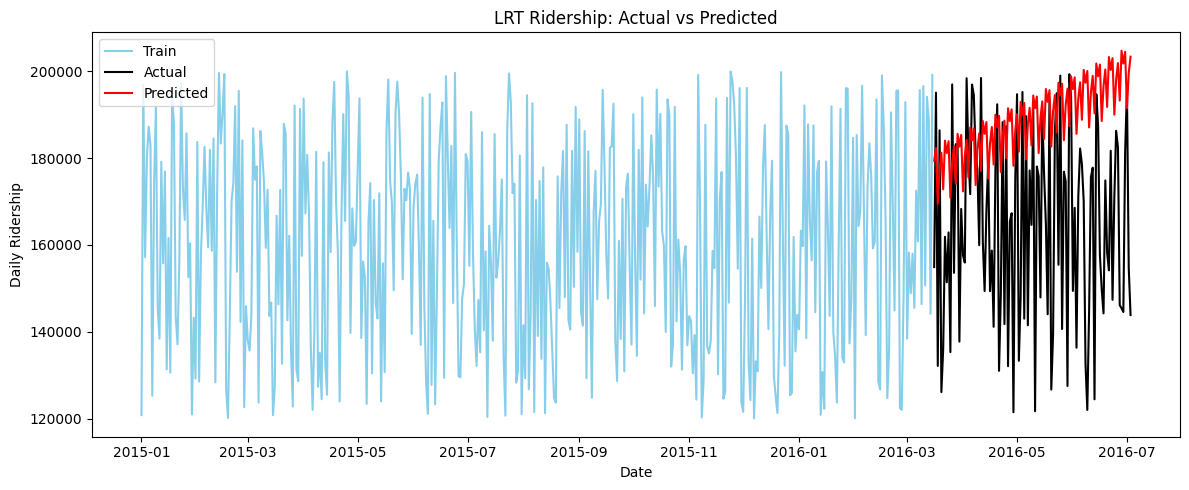

In [24]:
def train_forecast_evaluate_plot(data, transport_type):
    print(f"\n🔍 Transport Type: {transport_type}")

    # Filter for specific type
    df_type = data[data['Type'] == transport_type].copy()
    df_type.set_index('Date', inplace=True)
    df_type = df_type.asfreq('D')  # ensure daily frequency

    # Train-test split
    train_size = int(len(df_type) * 0.8)
    train, test = df_type.iloc[:train_size], df_type.iloc[train_size:]

    # Fit SARIMA model
    model = SARIMAX(train['Daily Ridership'], order=(1,1,1), seasonal_order=(1,1,1,7))
    result = model.fit(disp=False)

    # Forecast
    forecast = result.predict(start=test.index[0], end=test.index[-1])

    # Evaluation
    mae = mean_absolute_error(test['Daily Ridership'], forecast)
    rmse = np.sqrt(mean_squared_error(test['Daily Ridership'], forecast))
    mape = np.mean(np.abs((test['Daily Ridership'] - forecast) / test['Daily Ridership'])) * 100

    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.2f} %")

    # Plotting
    plt.figure(figsize=(12, 5))
    plt.plot(train.index, train['Daily Ridership'], label='Train', color='skyblue')
    plt.plot(test.index, test['Daily Ridership'], label='Actual', color='black')
    plt.plot(forecast.index, forecast, label='Predicted', color='red')
    plt.title(f'{transport_type} Ridership: Actual vs Predicted')
    plt.xlabel('Date')
    plt.ylabel('Daily Ridership')
    plt.legend()
    plt.tight_layout()
    plt.show()
for t_type in ['Bus', 'MRT', 'LRT']:
    train_forecast_evaluate_plot(df, t_type)


In [11]:
import pandas as pd

# Combine all data for export
export_df = df_pivot.copy()

# Add smoothed data
for col in fuzzy_smoothed.columns:
    export_df[col] = fuzzy_smoothed[col]

# Add forecasts
for mode in forecast_results:
    export_df[f'{mode}_Forecast'] = forecast_results[mode]['forecast']

# Save to Excel
export_df.to_excel("Forecasts_with_Fuzzy.xlsx")

# Download
from google.colab import files
files.download("Forecasts_with_Fuzzy.xlsx")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>